## McNulty - Terror Inc

Question: what variables/situations allow us to predict hostage outcomes (killed, released, escaped etc.) in terrorist incidents?

Furthermore, can we predict accurately given data that would also be available to law enforcement / detectives / state intelligence etc. in real time?

It would be really powerful if we used only info that’s say, publicly available within 30 min or something
of any given attack

Two approaches:
1. Hypothesis testing models
2. Kitchen Sink models

What matters more, recall or precision?
- Well, I want to know which things predict which hostage situations (impossible with random forests?)
- The ultimate goal is to aid law enforcement - so what's worse, a false negative or a false positive?
    - Is it worse for me to say that a hostage situation is going to turn out poorly incorrectly? 
    - Or worse for me to say that it will turn out good and then it turns out bad?
    
- Really, what I need is to see what features MATTER the most. We can't make causal claims. But, with a reduced feature set, using logistic regression, we can interpret what matters. 
- What are some actions that law enforcement / negotiators can take? I really want to see what ransom contributes.

Constraints:
- 

### Setup

In [343]:
#data handling/prediction
import pandas as pd
import numpy as np
import re
import pickle

#statsmodels
from statsmodels.discrete.discrete_model import Logit as sml
import statsmodels.api as sm

# sklearn
from sklearn.tree import DecisionTreeClassifier # decision trees
from sklearn.ensemble import RandomForestClassifier # baggers and random forests
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split # train test split, of course
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix # no problem
from sklearn.metrics import classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

# viz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# decision tree viz
from sklearn.externals.six import StringIO # uh ok
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz # visualization libraries. cool

In [344]:
# pandas options
pd.set_option("max_column",200)
pd.set_option("max_r",200)

In [345]:
def ends(df,n_rows = 5):
    ends_df = pd.concat([df.head(n_rows),
                         df.tail(n_rows)])
    return ends_df

In [346]:
data = pd.read_pickle ('gtd.p')

### Data Cleaning

This is a very cheery dataset! Let's see what awful things we can learn about this wonderful world.

Some intriguing observations:
- different ways to get at the same information: example "ishostkid" vs "attacktype", 'nkillus' vs 'natlty' etc. Not always match up completely even though they should, in theory!

In [293]:
data[(data.ishostkid == 1)].hostkidoutcome_txt.value_counts().sum()

9842

In [ ]:
explore2 = data[(data.ishostkid == 1)]

In [278]:
hostage_mask = (
          (data.ishostkid == 1) # is the attack a hostage-scenario, kidnapping, or hijacking scenario?
         &(data.nreleased >= 0) # remove all 'unknowns' (coded as -99)
         &(data.nhostkid  >=0) # remove all 'unknowns' (coded as -99)
         &(data.ransom >= 0) # remove all 'unknowns' (coded as -99)
         &(data.gname != 'Unknown') # remove all 'unknowns' (coded as 'Unknown')
         &(data.hostkidoutcome_txt != 'Unknown') # remove all ambiguous/unknown labels in DV
         &(data.hostkidoutcome_txt != 'Attempted Rescue') # remove all ambiguous/unknown labels in DV
         &(data.hostkidoutcome_txt != 'Combination') # remove all ambiguous/unknown labels in DV     
) 

data[hostage_mask].shape

(3393, 135)

In [7]:
hostages = data[hostage_mask].dropna(subset=(['hostkidoutcome_txt'])) # make sure no missing values on the y

hostages.shape

(3381, 135)

### Naive Exploratory Data Analysis

#### Data by individual hostages

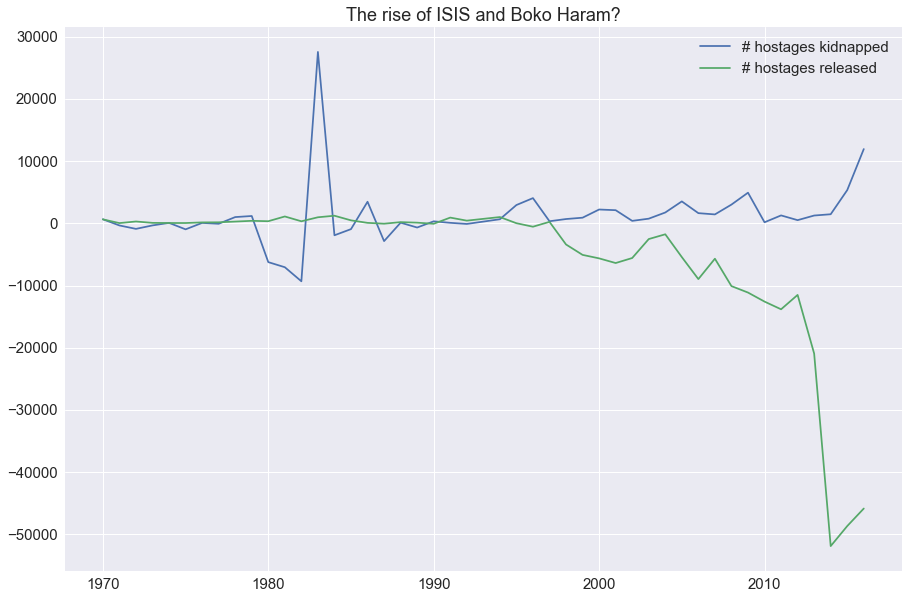

In [349]:
import matplotlib 
plt.figure(figsize = (15,10))

font = {'size'   : 16}

matplotlib.rc('font', **font)

plt.plot(data.groupby(['iyear'])['nhostkid'].sum())
plt.plot(data.groupby(['iyear'])['nreleased'].sum())

plt.title('The rise of ISIS and Boko Haram?')

plt.legend(['# hostages kidnapped','# hostages released']);

# this isn't accurate at all - i'm missing hijacking victims
# once I get those, hopefully it makes more sense
# (blue should never be lower than gold, at the least, equal)


#### Data by hostage event outcome

In [271]:
outcome = hostages.hostkidoutcome_txt.value_counts()
print(f'Total num of hostage events from 1970 to 2016: {outcome.sum()}')
print('\nNumber of events where:')
outcome

Total num of hostage events from 1970 to 2016: 3381

Number of events where:


Hostage(s) released by perpetrators               1691
Hostage(s) killed (not during rescue attempt)     1355
Successful Rescue                                  251
Hostage(s) escaped (not during rescue attempt)      84
Name: hostkidoutcome_txt, dtype: int64

In [270]:
outcome_by_year = hostages.groupby(['iyear']).hostkidoutcome_txt.value_counts()

outcome_by_year

### How could I plot this?

iyear  hostkidoutcome_txt                            
1970   Hostage(s) released by perpetrators                25
       Hostage(s) killed (not during rescue attempt)       4
       Successful Rescue                                   1
1971   Hostage(s) released by perpetrators                10
       Hostage(s) escaped (not during rescue attempt)      1
       Hostage(s) killed (not during rescue attempt)       1
1972   Hostage(s) released by perpetrators                 4
       Hostage(s) killed (not during rescue attempt)       2
1973   Hostage(s) released by perpetrators                19
       Hostage(s) killed (not during rescue attempt)       3
       Successful Rescue                                   2
1974   Hostage(s) released by perpetrators                12
       Hostage(s) killed (not during rescue attempt)       3
1975   Hostage(s) released by perpetrators                16
       Hostage(s) killed (not during rescue attempt)       1
       Successful Rescue       

### Wizened Exploratory Data Analysis

#### Relabeling

In [9]:
outcome_labels = {'Hostage(s) released by perpetrators':'released/rescued',
                  'Successful Rescue': 'released/rescued',
                  'Hostage(s) escaped (not during rescue attempt)':'released/rescued',
                  'Hostage(s) killed (not during rescue attempt)':'killed'}

# I love regex - remove anything that's not a letter from the targtype1 labels
targtype1_labels = {label:re.sub(r'[^\w+]','',label) for label in list(hostages.targtype1_txt.unique())}
region_labels = {label:re.sub(r'[^\w+]','',label) for label in list(hostages.region_txt.unique())}


# let's rename some things
hostages['hostkidoutcome_txt_new'] = hostages['hostkidoutcome_txt'].map(outcome_labels)
hostages['targtype1_txt_new'] = hostages['targtype1_txt'].map(targtype1_labels)
hostages['region_txt_new'] = hostages['region_txt'].map(region_labels)

hostages.rename(columns = {'crit1':'greater_purpose','crit2':'public_terror','crit3':'violate_geneva'},
                inplace = True)

In [10]:
hostages.shape

(3381, 138)

#### Dummies and Final Data Prep

Hypothesis/Restricted Model - Jointly available and meaningful information
- Country, types of targets, month, year, ransom, extended incident, num hostages

Kitchen sink:
- all of the above, plus:
- nationality of victims, name of group who committed the attack, number of terrorists killed
- day of the month, was it part of a larger incident?
- terrorism categorization info, number of terrorists killed

In [11]:
# dummy variables

country_dums = pd.get_dummies(hostages.country_txt, prefix = 'country') # kitchen only
natlty1_dums = pd.get_dummies(hostages.natlty1_txt, prefix = 'natlty') # kitchen only
gname_dums =   pd.get_dummies(hostages.gname, prefix = 'attackby') # kitchen only

targtype1_dums = pd.get_dummies(hostages.targtype1_txt_new, prefix = 'targ') # both


# hypothesis set of dummies
h_dummies = pd.concat([country_dums,
                      targtype1_dums], axis = 1)

# kitchen sink sit of dummies
k_dummies = pd.concat([country_dums,
                     targtype1_dums,
                     natlty1_dums,
                     gname_dums], axis = 1)

# hypothesis set of dummies
h_cats = hostages[['iyear',
                  'imonth',
                  'ransom',
                  'extended']]

# kitchen sink set of dummies
k_cats = hostages[['iyear', # both
                 'imonth', # both
                 'iday', # kitchen only - why should day of the month matter?
                 'ransom', # both
                 'extended', # both
                 'multiple', # kitchen only
                 'greater_purpose', # kitchen only
                 'public_terror', # kitchen only
                 'violate_geneva']] # kitchen only

# hypothesis set of continuous variables
h_conts = hostages['nhostkid']

# kitchen sink set of continuous variables
k_conts = hostages[['nhostkid','nkillter']]

DV = hostages.hostkidoutcome_txt_new

In [12]:
# data for the hypothesis / restricted feature model
H_DATA = pd.concat([h_conts,
                    h_cats,
                    h_dummies,
                    DV],axis = 1).dropna()

# data for the kitchen sink model - throw everything in!
K_DATA = pd.concat([k_conts,
                    k_cats,
                    k_dummies,
                    DV],axis = 1).dropna()

In [14]:
print(f"""
Shape of our hypothesis data:
{H_DATA.shape[0]} rows, {H_DATA.shape[1]} columns

Shape of our kitchen-sink data:
{K_DATA.shape[0]} rows, {K_DATA.shape[1]} columns
""")


Shape of our hypothesis data:
3381 rows, 136 columns

Shape of our kitchen-sink data:
2652 rows, 787 columns



In [18]:
hX = H_DATA.iloc[:,:-1]
hy = H_DATA.iloc[:,-1]

kX = K_DATA.iloc[:,:-1]
ky = K_DATA.iloc[:,-1]

In [19]:
print("Data shapes - hypothesis model")
print(hX.shape, hy.shape,"\n")

print("Data shapes - kitchen model")
print(kX.shape, ky.shape,"\n")

Data shapes - hypothesis model
(3381, 135) (3381,) 

Data shapes - kitchen model
(2652, 786) (2652,) 



In [20]:
# hypothesis train test split
hX_train, hX_test, hy_train, hy_test = train_test_split(hX, hy, test_size=0.3)

# kitchen-sink train test split
kX_train, kX_test, ky_train, ky_test = train_test_split(kX, ky, test_size=0.3)

#### Examining Our Outcome Counts

In [21]:
print("Hypothesis Model outcome counts\n")

print("FULL SET: ")
print(hy.value_counts().to_frame(),"\n")
print("TRAINING SET: ")
print(hy_train.value_counts().to_frame(),"\n")
print("TEST SET: ")
print(hy_test.value_counts().to_frame(),"\n")

print("="*35,'\n')
print("Kitchen Sink Model outcome counts\n")

print("FULL SET: ")
print(ky.value_counts().to_frame(),"\n")
print("TRAINING SET: ")
print(ky_train.value_counts().to_frame(),"\n")
print("TEST SET: ")
print(ky_test.value_counts().to_frame(),"\n")


Hypothesis Model outcome counts

FULL SET: 
                  hostkidoutcome_txt_new
released/rescued                    2026
killed                              1355 

TRAINING SET: 
                  hostkidoutcome_txt_new
released/rescued                    1396
killed                               970 

TEST SET: 
                  hostkidoutcome_txt_new
released/rescued                     630
killed                               385 


Kitchen Sink Model outcome counts

FULL SET: 
                  hostkidoutcome_txt_new
released/rescued                    1459
killed                              1193 

TRAINING SET: 
                  hostkidoutcome_txt_new
released/rescued                    1032
killed                               824 

TEST SET: 
                  hostkidoutcome_txt_new
released/rescued                     427
killed                               369 



In [281]:
explore = data.dropna(subset = (['hostkidoutcome_txt']))

outcome_labels = {'Hostage(s) released by perpetrators':'Released / Rescued',
                  'Successful Rescue': 'Released / Rescued',
                  'Hostage(s) escaped (not during rescue attempt)':'Released / Rescued',
                  'Hostage(s) killed (not during rescue attempt)':'Killed',
                  'Unknown':'Unknown'}

explore['outcomes'] = explore['hostkidoutcome_txt'].map(outcome_labels)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Pie Chart of All Outcomes

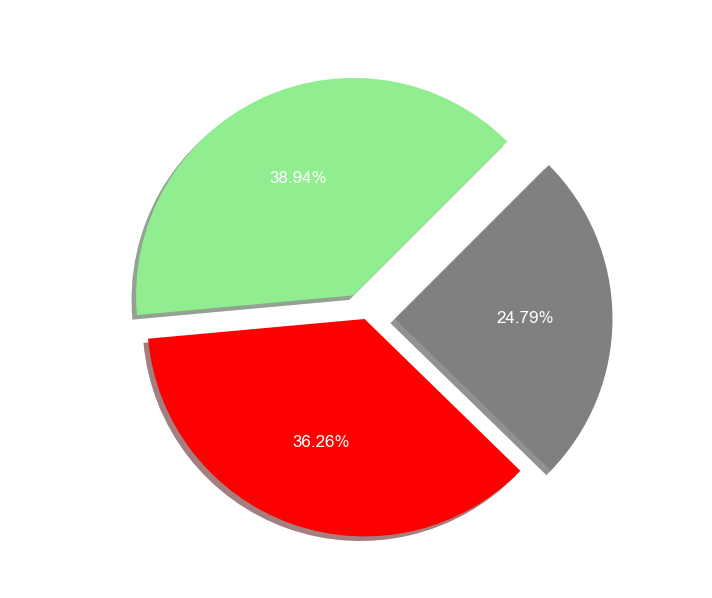

In [350]:
explore_counts = explore.outcomes.value_counts()

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')

p = plt.pie(explore_counts,
          labels = ['Released, Rescued, or Escaped','Killed', 'Unknown'],
          autopct = '%.2f%%',
          colors = ['lightgreen', 'red','grey'],
          textprops = {'fontsize': 17,'color':'white'},
          explode = (.12, 0.0, 0.14),
          startangle = 45,
          shadow = True)

plt.title(f'Outcomes of {explore.outcomes.shape[0]} hostage situations\n',
          fontdict={'fontsize': 18, 
                    'weight':'semibold',
                   'color':'white'});

In [294]:
r1mask = ((H_DATA.ransom == 1))
r0mask = ((H_DATA.ransom == 0))

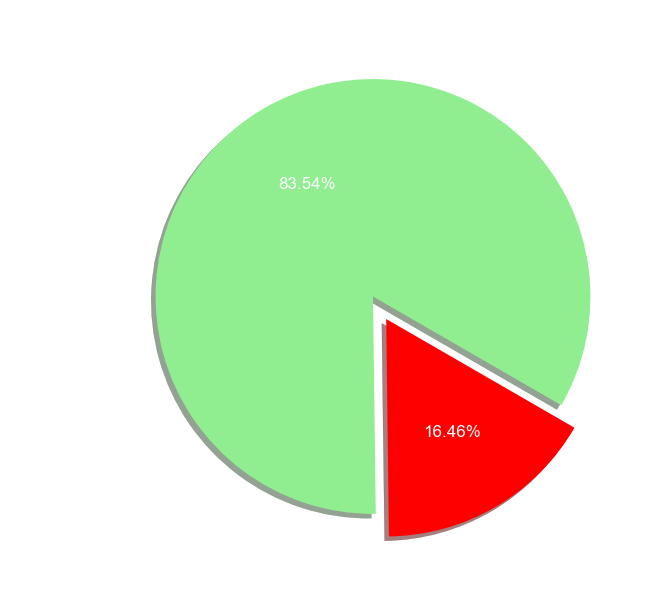

In [352]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')

p = plt.pie(H_DATA[r1mask].hostkidoutcome_txt_new.value_counts(),
            labels = ['Released, Rescued, or Escaped','Killed'],
            autopct = '%.2f%%',
            colors = ['lightgreen', 'red'],
            textprops = {'fontsize': 17,'color':'white'},
            explode = (.12, 0.0),
            startangle = -30,
            shadow = True)

plt.title(f'Outcomes when ransom demanded\n',
          fontdict={'fontsize': 18, 
                    'weight':'semibold',
                   'color':'white'});

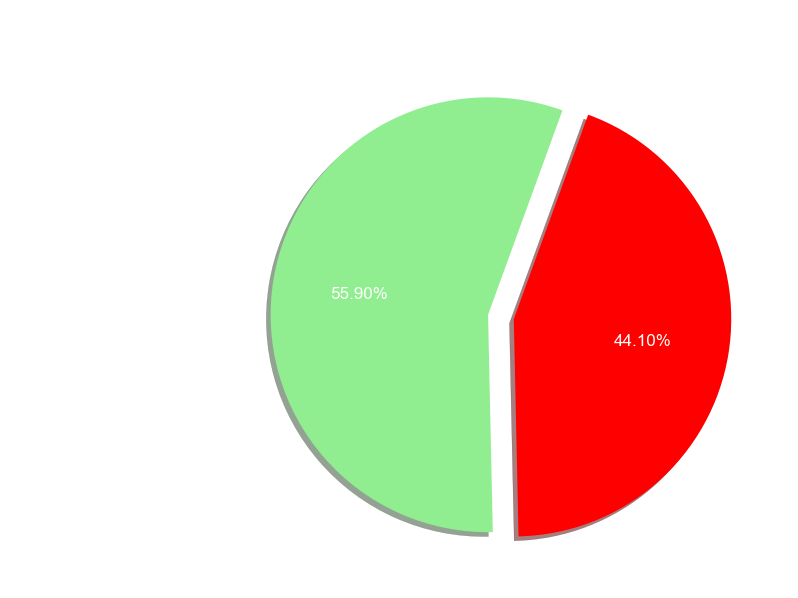

In [351]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')

p = plt.pie(H_DATA[r0mask].hostkidoutcome_txt_new.value_counts(),
            labels = ['Released, Rescued, or Escaped','Killed'],
            autopct = '%.2f%%',
            colors = ['lightgreen', 'red'],
            textprops = {'fontsize': 17,'color':'white'},
            explode = (.12, 0.0),
            startangle = 70,
            shadow = True)

plt.title(f'Outcomes when ransom NOT demanded\n',
          fontdict={'fontsize': 18, 
                    'weight':'semibold',
                    'color':'white'});

In [328]:
explore.nhostkid.count()

9844

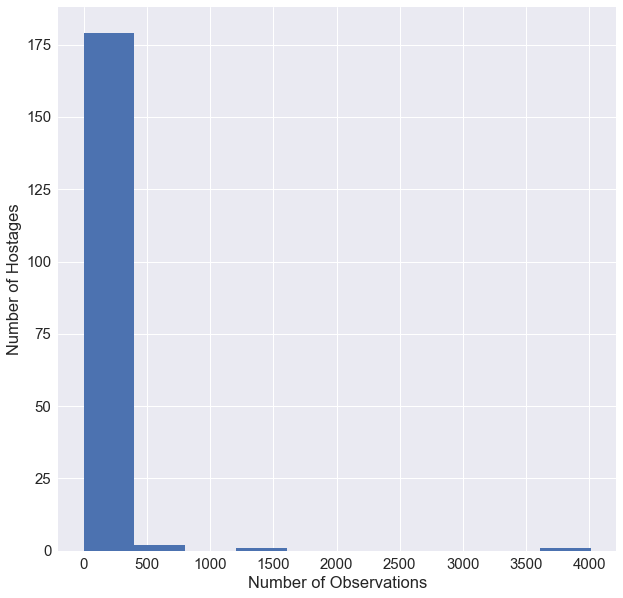

In [340]:
plt.figure(figsize = (10,10))
plt.hist(explore[explore.nhostkid >= 1].nhostkid.value_counts().T)
plt.xlabel('Number of Observations')
plt.ylabel('Number of Hostages')
plt.show();


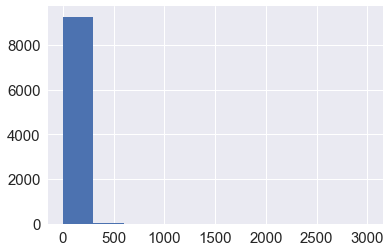

In [314]:
explore[explore.nhostkid >= 0].nhostkid.hist()

### Modeling

#### SKLearn Logistic Regression

In [ ]:
def evaluate_classifier(estimator, features, target):
    import 
    

In [164]:
# Hypothesis Test
h_hostage_logit = LogisticRegression(fit_intercept = True, class_weight = 'balanced')
h_hostage_logit.fit(hX_train,
                  hy_train)

print('\n')
print('Hypothesis Test - SKLearn LOGISITIC REGRESSION\n')
print(classification_report(hy_test,
                            h_hostage_logit.predict(hX_test)))

# I want to interpret my betas - I want to know what makes 'killed' more likely than 'released'
# Normalize? 

h_hostage_logit_results = pd.DataFrame({'feature':hX.columns.tolist(),
                                'coefficients':h_hostage_logit.coef_[0]
                               }).sort_values('coefficients',ascending = False)

print(ends(h_hostage_logit_results,10))

print("\n","="*55)

# Kitchen Sink
k_hostage_logit = LogisticRegression(fit_intercept = True, class_weight = 'balanced')
k_hostage_logit.fit(kX_train,
                  ky_train)


print('\n')
print('Kitchen Sink Model - SKLearn LOGISITIC REGRESSION\n')
print(classification_report(ky_test,
                            k_hostage_logit.predict(kX_test)))

k_hostage_logit_results = pd.DataFrame({'feature':kX.columns.tolist(),
                                'coefficients':k_hostage_logit.coef_[0]
                               }).sort_values('coefficients',ascending = False)

print(ends(k_hostage_logit_results,10))



Hypothesis Test - SKLearn LOGISITIC REGRESSION

                  precision    recall  f1-score   support

          killed       0.64      0.82      0.72       385
released/rescued       0.87      0.72      0.79       630

     avg / total       0.78      0.76      0.76      1015

     coefficients                         feature
96       1.723945                   country_Sudan
105      1.532193                 country_Ukraine
60       1.525838                 country_Lebanon
120      1.164309           targ_JournalistsMedia
128      1.108175          targ_Telecommunication
133      1.090068                  targ_Utilities
39       1.012756                  country_France
79       1.012557                country_Paraguay
37       0.997321                country_Ethiopia
123      0.984728                        targ_NGO
125     -1.153268                     targ_Police
62      -1.160979                   country_Libya
35      -1.182393             country_El Salvador
43      -1.1886

#### Statsmodel Logistic Regression

In [ ]:
sm_outcome_labels = {'released':1,
                     'killed':0}

# Hypothesis Test
hy_sm = hy.map(sm_outcome_labels)
hX_sm = sm.tools.add_constant(hX)

h_sm_logit = sml(hy_sm, hX_sm).fit()
h_sm_logit.summary()

#### Support Vector Machines

In [154]:
# Hypothesis testing 

h_hostageSVC = SVC(class_weight = 'balanced')
h_hostageSVC.fit(hX_train,hy_train)

print('\n')
print('Hypothesis Test - SUPPORT VECTOR MACHINES\n')
print(classification_report(hy_test,
                            h_hostageSVC.predict(hX_test)))

print("="*55)
# Kitchen Sink testing

k_hostageSVC = SVC(class_weight = 'balanced')
k_hostageSVC.fit(kX_train,ky_train)

print('\n')
print('Kitchen Sink Model - SUPPORT VECTOR MACHINES\n')
print(classification_report(ky_test,
                            k_hostageSVC.predict(kX_test)))



Hypothesis Test - SUPPORT VECTOR MACHINES

                  precision    recall  f1-score   support

          killed       0.59      0.76      0.67       385
released/rescued       0.82      0.68      0.75       630

     avg / total       0.74      0.71      0.72      1015



Kitchen Sink Model - SUPPORT VECTOR MACHINES

                  precision    recall  f1-score   support

          killed       0.64      0.81      0.71       369
released/rescued       0.79      0.60      0.68       427

     avg / total       0.72      0.70      0.70       796



#### Naive Bayes Classifier

In [155]:
# Gaussian Naive Bayes on hypothesis test data

h_NB = GaussianNB()
h_NB.fit(hX_train,hy_train)

print('\n')
print('Hypothesis Test - GAUSSIAN NAIVE BAYES CLASSIFIER \n')
print(classification_report(hy_test,
                            h_NB.predict(hX_test)))


print("="*55)
# Gaussian Naive Bayes on kitchen sink data

k_NB = GaussianNB()
k_NB.fit(kX_train,ky_train)

print('\n')
print('Kitchen Sink Model - GAUSSIAN NAIVE BAYES CLASSIFIER\n')
print(classification_report(ky_test,
                            k_NB.predict(kX_test)))



Hypothesis Test - GAUSSIAN NAIVE BAYES CLASSIFIER 

                  precision    recall  f1-score   support

          killed       0.42      0.96      0.59       385
released/rescued       0.89      0.19      0.32       630

     avg / total       0.71      0.48      0.42      1015



Kitchen Sink Model - GAUSSIAN NAIVE BAYES CLASSIFIER

                  precision    recall  f1-score   support

          killed       0.51      0.96      0.66       369
released/rescued       0.84      0.20      0.33       427

     avg / total       0.69      0.55      0.48       796



#### Decision Trees

In [382]:
# Hypothesis Test Model
h_dt_hostages = DecisionTreeClassifier(max_depth = 5)
h_dt_hostages.fit(hX_train, hy_train)

h_dt_hostages_import = pd.DataFrame({'feature':hX.columns.tolist(),
                                    'importance':h_dt_hostages.feature_importances_}).sort_values('importance',
                                                                          ascending = False)

print('\n')
print('Hypothesis Test Model - DECISION TREES \n')
print(classification_report(hy_test,h_dt_hostages.predict(hX_test)))
print(h_dt_hostages.score(hX_test,hy_test))
print("\nWhat's important in predicting the outcome of hostage situations?\n")
print(h_dt_hostages_import.head(7),'\n')

print("="*65)

# # Kitchen Sink Model
# k_dt_hostages = DecisionTreeClassifier(max_depth = 5)
# k_dt_hostages.fit(kX_train, ky_train)

# k_dt_hostages_import = pd.DataFrame({'feature':kX.columns.tolist(),
#                                     'importance':k_dt_hostages.feature_importances_}).sort_values('importance',
#                                                                           ascending = False)

# print('\n')
# print('Kitchen Sink Model - DECISION TREES \n')
# print(classification_report(ky_test,k_dt_hostages.predict(kX_test)))
# print("\nWhat's important in predicting the outcome of hostage situations?\n")
# print(k_dt_hostages_import.head(),'\n')



Hypothesis Test Model - DECISION TREES 

                  precision    recall  f1-score   support

          killed       0.65      0.63      0.64       385
released/rescued       0.78      0.80      0.79       630

     avg / total       0.73      0.73      0.73      1015

0.733990147783

What's important in predicting the outcome of hostage situations?

                          feature  importance
4                        extended    0.242497
1                           iyear    0.167986
0                        nhostkid    0.120219
50                   country_Iraq    0.095908
115                 targ_Business    0.093407
126  targ_PrivateCitizensProperty    0.083718
125                   targ_Police    0.038987 



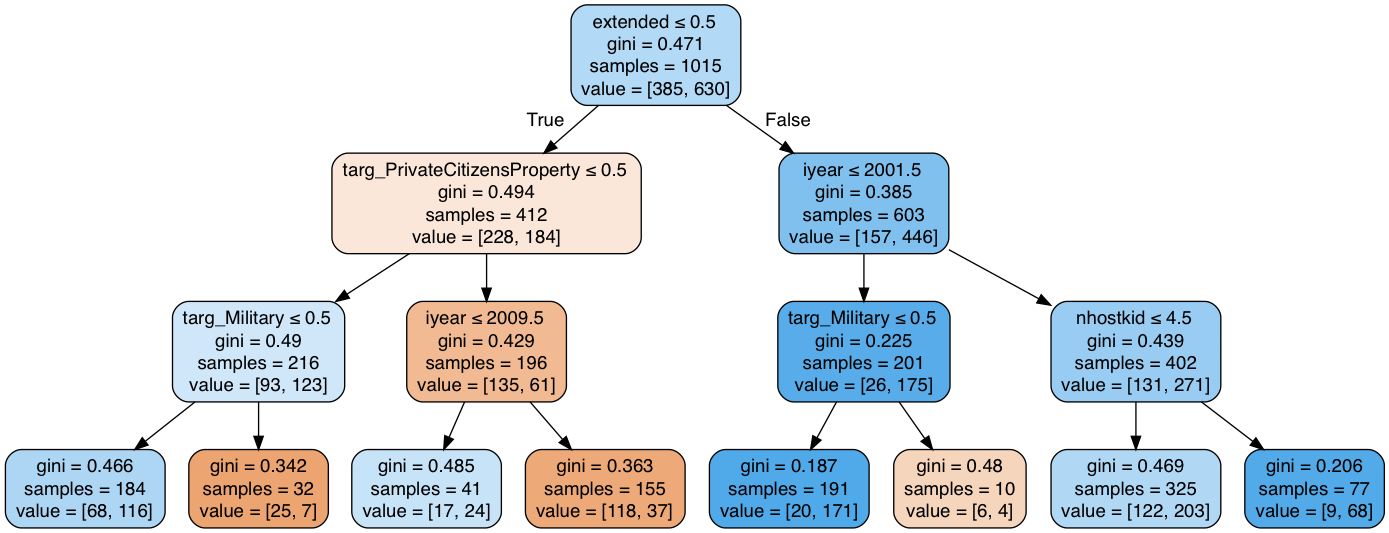

In [378]:
# Visualize decision tree - Hypothesis Test
dot_data = StringIO()
export_graphviz(h_dt_hostages.fit(hX_test, hy_test), out_file= dot_data,
                    feature_names=hX_test.columns.tolist(),  
                    filled=True, rounded=True, 
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

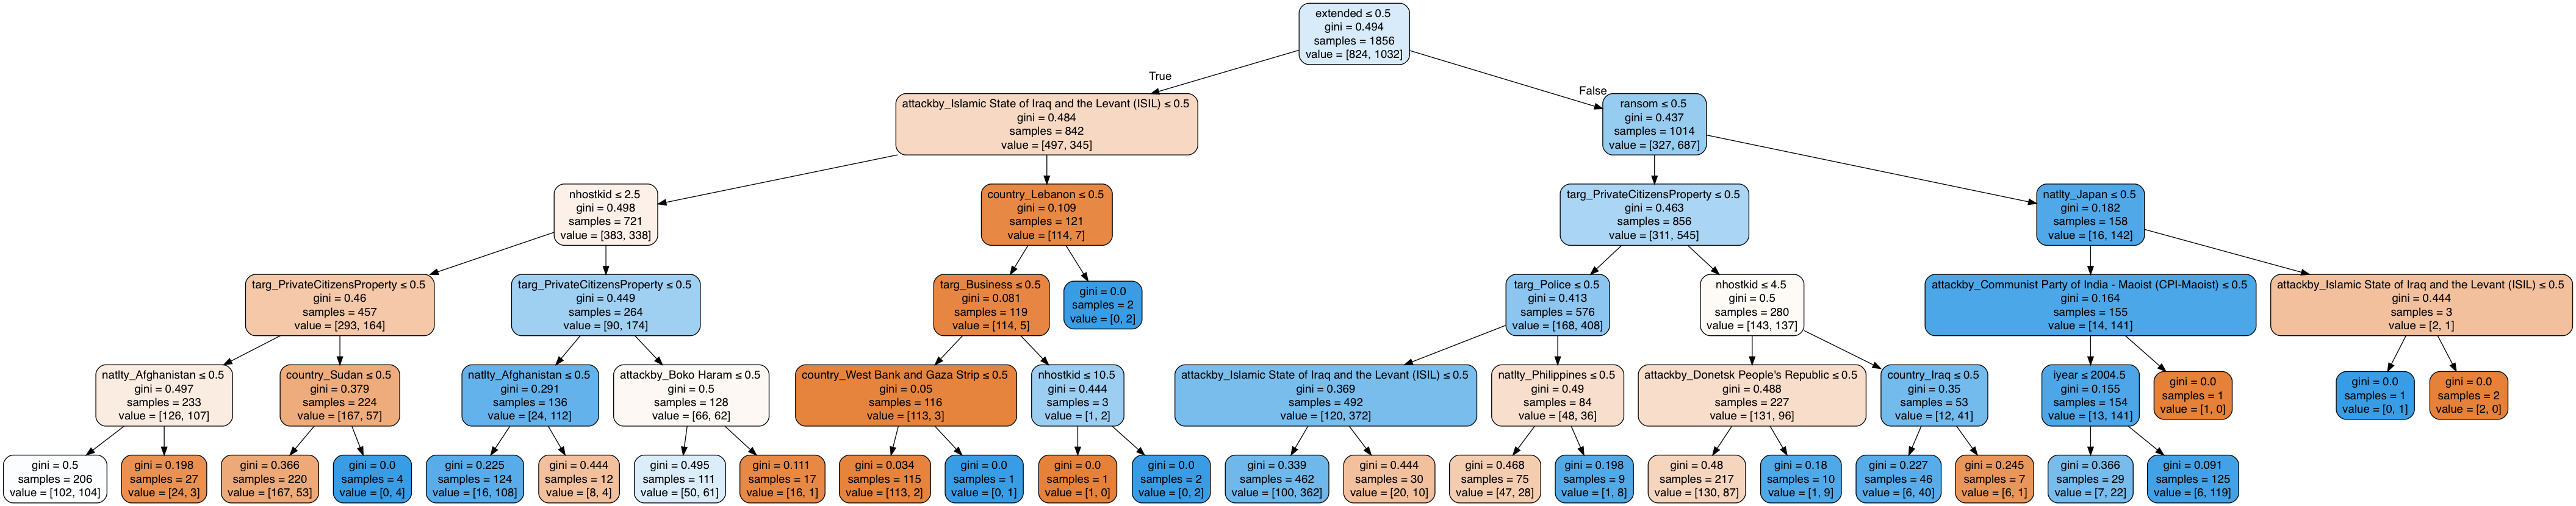

In [372]:
# Visualize decision tree - Hypothesis Test
dot_data = StringIO()  
export_graphviz(k_dt_hostages, out_file= dot_data,
                    feature_names=kX_train.columns.tolist(),  
                    filled=True, rounded=True, 
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

#### Random Forest

In [159]:
h_rf_hostages = RandomForestClassifier(500,
                       max_depth = 50,
                       min_samples_leaf = 75,
                       max_features = 0.3,
                       min_samples_split = 200
                      )

h_rf_hostages.fit(hX_train, hy_train)

print(classification_report(hy_test,h_rf_hostages.predict(hX_test)))


                  precision    recall  f1-score   support

          killed       0.67      0.54      0.60       385
released/rescued       0.75      0.84      0.79       630

     avg / total       0.72      0.73      0.72      1015



In [160]:
# Hypothesis Test Model
h_rf_hostages = RandomForestClassifier()
h_rf_hostages.fit(hX_train, hy_train)

h_rf_hostages_import = pd.DataFrame({'feature':hX.columns.tolist(),
                                    'importance':h_rf_hostages.feature_importances_}).sort_values('importance',
                                                                          ascending = False)

print('\n')
print('Hypothesis Test Model - RANDOM FOREST\n')
print(classification_report(hy_test,h_rf_hostages.predict(hX_test)))
print("\nWhat's important in predicting the outcome of hostage situations?\n")
print(h_rf_hostages_import.head(),'\n')

print("="*65)

# Kitchen Sink Model
k_rf_hostages = RandomForestClassifier()
k_rf_hostages.fit(kX_train, ky_train)

k_rf_hostages_import = pd.DataFrame({'feature':kX.columns.tolist(),
                                    'importance':k_rf_hostages.feature_importances_}).sort_values('importance',
                                                                          ascending = False)

print('\n')
print('Kitchen Sink Model - RANDOM FOREST\n')
print(classification_report(ky_test,k_rf_hostages.predict(kX_test)))
print("\nWhat's important in predicting the outcome of hostage situations?\n")
print(k_rf_hostages_import.head(),'\n')



Hypothesis Test Model - RANDOM FOREST

                  precision    recall  f1-score   support

          killed       0.68      0.76      0.72       385
released/rescued       0.84      0.78      0.81       630

     avg / total       0.78      0.77      0.78      1015


What's important in predicting the outcome of hostage situations?

                          feature  importance
1                           iyear    0.169366
2                          imonth    0.149862
0                        nhostkid    0.111830
4                        extended    0.056208
126  targ_PrivateCitizensProperty    0.040352 



Kitchen Sink Model - RANDOM FOREST

                  precision    recall  f1-score   support

          killed       0.75      0.76      0.75       369
released/rescued       0.79      0.78      0.78       427

     avg / total       0.77      0.77      0.77       796


What's important in predicting the outcome of hostage situations?

                                     

#### Hyperparameter Random Search

##### EC2 Prep

In [22]:
pd.to_pickle(H_DATA,'/users/xerocomplex/Dropbox/H_DATA.p')
pd.to_pickle(K_DATA,'/users/xerocomplex/Dropbox/K_DATA.p')

##### RUN IN EC2 OR YOU WILL HATE YOUR LIFE ###

In [ ]:

#data handling/prediction
import pandas as pd
import numpy as np
import re
import pickle

# sklearn
from sklearn.ensemble import RandomForestClassifier # baggers and random forests
from sklearn.model_selection import train_test_split # train test split, of course

# Random Searching
from sklearn.model_selection import RandomizedSearchCV


#H_DATA = pd.read_pickle('home/jon/Dropbox/H_DATA.p')
#K_DATA = pd.read_pickle('home/jon/Dropbox/K_DATA.p')

hX = H_DATA.iloc[:,:-1]
hy = H_DATA.iloc[:,-1]

kX = K_DATA.iloc[:,:-1]
ky = K_DATA.iloc[:,-1]

# train test split
hX_train, hX_test, hy_train, hy_test = train_test_split(hX, hy, test_size=0.3)
kX_train, kX_test, ky_train, ky_test = train_test_split(kX, ky, test_size=0.3)

##### RANDOM GRID ######
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 5000, num = 100)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 15)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

###### RANDOM GRID END #######

####  HYP MODEL RANDOM SEARCH ####
# Use the random grid to search for best hyperparameters
# First create the base model to tune
h_rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation,
# search across 10 different combinations, and use all available cores
h_rf_random = RandomizedSearchCV(estimator = h_rf, param_distributions = random_grid,
                               n_iter = 30,
                               cv =5,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
h_rf_random.fit(hX_train, hy_train)

### hypothesis dump
pickle.dump(h_rf_random.best_estimator_,
            open("h_estimator.p", "wb" ))


####  KITCHEN MODEL RANDOM SEARCH ####
# Use the random grid to search for best hyperparameters
# First create the base model to tune
k_rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation,
# search across 10 different combinations, and use all available cores
k_rf_random = RandomizedSearchCV(estimator = k_rf, param_distributions = random_grid,
                               n_iter = 30,
                               cv =5,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
# Fit the random search model
k_rf_random.fit(kX_train, ky_train)

### kitchen dump
pickle.dump(k_rf_random.best_estimator_,
            open( "k_estimator.p", "wb" ))


##### Let's see what we got!

In [384]:
print(new_h_rf.score(hX_test,hy_test))
print(new_k_rf.score(kX_test,ky_test))

0.8039408867
0.825376884422


In [383]:
h_est = pickle.load(open("/users/xerocomplex/Dropbox/h_estimator.p", "rb" ))
k_est = pickle.load(open("/users/xerocomplex/Dropbox/k_estimator.p", "rb" ))

#####

new_h_rf = h_est

new_h_rf.fit(hX_train, 
             hy_train)      

new_h_rf_import = pd.DataFrame({'feature':hX.columns.tolist(),
                                'importance':new_h_rf.feature_importances_}).sort_values('importance',
                                                                          ascending = False)

print("\nWhat's important in predicting the outcome of hostage situations?\n")
print("\n\t\tHYPOTHESIS TEST - HYPERPARAMETER TUNED RF\n")
print(new_h_rf_import.head(5),"\n")
print(classification_report(hy_test,new_h_rf.predict(hX_test)))

print("="*65) ######

new_k_rf = k_est

new_k_rf.fit(kX_train, 
             ky_train)      

new_k_rf_import = pd.DataFrame({'feature':kX.columns.tolist(),
                                'importance':new_k_rf.feature_importances_}).sort_values('importance',
                                                                          ascending = False)

print("\n\t\tWhat's important in predicting the outcome of hostage situations?\n")
print("\nKITCHEN SINK - HYPERPARAMETER TUNED RF\n")
print(new_k_rf_import.head(5),"\n")
print(classification_report(ky_test,new_k_rf.predict(kX_test)))


What's important in predicting the outcome of hostage situations?


		HYPOTHESIS TEST - HYPERPARAMETER TUNED RF

                          feature  importance
1                           iyear    0.144775
0                        nhostkid    0.096785
4                        extended    0.090741
126  targ_PrivateCitizensProperty    0.076695
50                   country_Iraq    0.070032 

                  precision    recall  f1-score   support

          killed       0.75      0.73      0.74       385
released/rescued       0.84      0.85      0.84       630

     avg / total       0.80      0.80      0.80      1015


		What's important in predicting the outcome of hostage situations?


KITCHEN SINK - HYPERPARAMETER TUNED RF

                          feature  importance
0                        nhostkid    0.073035
2                           iyear    0.052534
4                            iday    0.046600
132  targ_PrivateCitizensProperty    0.045264
6                        extende

### Visualization

Unique Actual Classes: 2
Unique Predicted Classes: 2
Total Test Observations: 1015


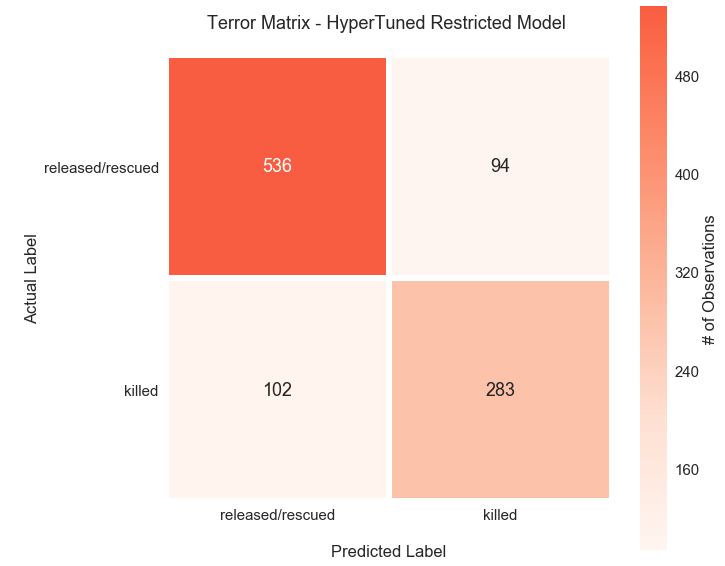

Unique Actual Classes: 2
Unique Predicted Classes: 2
Total Test Observations: 796


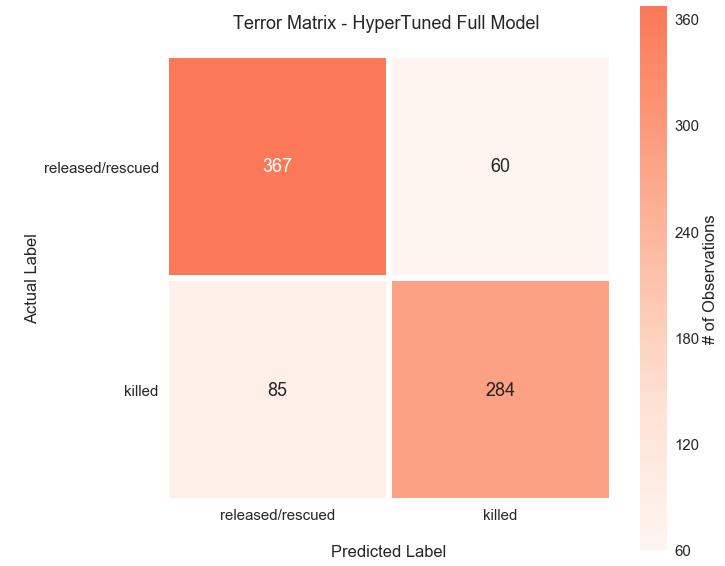

In [226]:
def create_hm(X, y, model, color_map, title):    
    
    labels = y.value_counts().index
    
    cm = confusion_matrix(y, model.predict(X), labels=labels)
    #cm = pd.DataFrame(cm / cm.sum(axis=1, keepdims=True))
    print('Unique Actual Classes:', 
          len(y.unique()))
    print('Unique Predicted Classes:', 
          len(pd.Series(model.predict(X)).unique()))
    print('Total Test Observations:', 
          len(y))
    
    ax, fig = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(cm, 
                     annot=True,
                     fmt = '.0f',
                     cmap = str(color_map),
                     center = np.mean(y.value_counts()),
                     linewidths=5,
                     square = True, 
                     cbar_kws = {"label": "# of Observations"})
    
    ax.set_title(f"Terror Matrix - {title} \n")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('\nActual Label')    
    ax.set_xlabel('\nPredicted Label')
    
    plt.yticks(rotation=0)
    #plt.xticks(rotation=90)
    sns.set(font_scale=1.5)
    plt.show()b
    

create_hm(hX_test,hy_test, new_h_rf, 'Reds', 'HyperTuned Restricted Model')
create_hm(kX_test,ky_test, new_k_rf, 'Reds', 'HyperTuned Full Model')


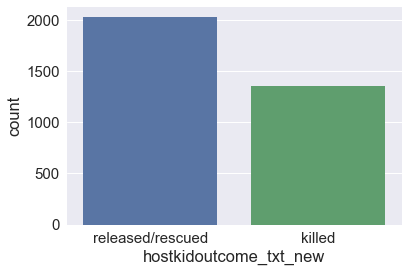

In [239]:
sns.countplot(H_DATA[H_DATA['hostkidoutcome_txt_new']])
sns.countplot(H_DATA[H_DATA])

In [263]:
print(round(1615/(1274 + 1615),2))
print(round(1274/(1274 + 1615),2))

print(round(411/(411 + 81),2))
print(round(81/(411 + 81),2))

0.56
0.44
0.84
0.16


In [259]:
print(H_DATA[H_DATA.ransom == 0]['hostkidoutcome_txt_new'].value_counts())

print(H_DATA[H_DATA.ransom == 1]['hostkidoutcome_txt_new'].value_counts())

released/rescued    1615
killed              1274
Name: hostkidoutcome_txt_new, dtype: int64
released/rescued    411
killed               81
Name: hostkidoutcome_txt_new, dtype: int64


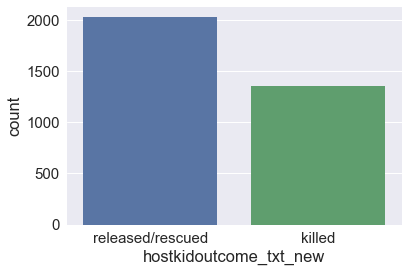

In [258]:
sns.countplot(x = H_DATA['hostkidoutcome_txt_new'])  

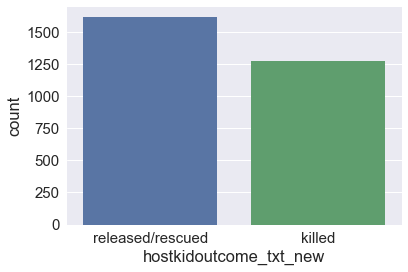

In [256]:
sns.countplot(x = H_DATA[H_DATA.ransom == 1]['hostkidoutcome_txt_new'])  

In [355]:
## Recall important when interfacing with families
## estimators 
new_h_rf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=80,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=5,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1269068980, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=80,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=5,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=585497806, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=80,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=5,
             min_weight_fr

In [363]:
vis_now = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=2, min_samples_split=5,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=278460959, splitter='best')

# Hypothesis Test Model
vis_now.fit(hX_train, hy_train)

vis_now_import = pd.DataFrame({'feature':hX.columns.tolist(),
                                    'importance':vis_now.feature_importances_}).sort_values('importance',
                                                                          ascending = False)

print('\n')
print('Hypothesis Test Model - DECISION TREES \n')
print(classification_report(hy_test,vis_now.predict(hX_test)))
print("\nWhat's important in predicting the outcome of hostage situations?\n")
print(vis_now_import.head(),'\n')

print("="*65)



Hypothesis Test Model - DECISION TREES 

                  precision    recall  f1-score   support

          killed       0.00      0.00      0.00       385
released/rescued       0.62      1.00      0.77       630

     avg / total       0.39      0.62      0.48      1015


What's important in predicting the outcome of hostage situations?

                 feature  importance
115        targ_Business    0.547604
25      country_Colombia    0.329000
0               nhostkid    0.074136
94         country_Spain    0.039985
5    country_Afghanistan    0.009276 



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
